In [6]:
import cv2
import numpy as np

import json
import glob
import tqdm
import personal_TEST
import importlib
from scipy.spatial.transform import Rotation
import itertools

In [7]:
# euler coordinates are in XYZ format in Blender

In [66]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/starlink_wpnp_filter_11_keypoints/1/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'starlink'
which_dataset = 1

In [86]:
def compute_histograms():
    angular_errors = []
    l2_pts_errors = []

    for json_file in tqdm.tqdm(json_files):
        example_data = json.loads(open(json_file).read())
        # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

        base_world_pts = np.array(example_data['world_keypoints'])
        # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
        # base_world_pts = base_world_pts*m

        observed_pts   = np.array(example_data['sensor_keypoints'])
        # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

        # blender_K = np.array(example_data['intrinsic_matrix'])
        # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
        K = np.eye(3)
        R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
        R = np.array(R)

        # r = Rotation.from_quat(np.array(R))
        # R = r.as_matrix()

        K = np.hstack((K, np.zeros((3,1))))
        Xworld = np.array(base_world_pts)
        Xcam = np.array(observed_pts)
        A = np.array(K)

        # load points
        # ET = personal_TEST.EPnPTest()
        # ET.load_custom_points_noplot(Xworld, Xcam, A)

        # run EPnP
        # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
        
        ########  ---------------------------------------rotation methods
        all_flags = [
            'SOLVEPNP_ITERATIVE', 
            'SOLVEPNP_EPNP', 
            'SOLVEPNP_P3P', 
            'SOLVEPNP_AP3P', 
            'SOLVEPNP_SQPNP'
        ]
        # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

        ang_error_each = []
        for flag in all_flags:
            try:
                success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
                estimated_rotation = Rotation.from_matrix(rotation_matrix)
                estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
            except:
                pass
            
            # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
            angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
            ang_error_each.append(angular_distance)
        
        angular_errors.append(ang_error_each)

    import matplotlib.pyplot as plt
    angular_errors = np.array(angular_errors)
    plt.figure(figsize=(16,3))
    num_bins = 100
    min_bin = 0
    max_bin = 180

    plt.title(f'Angular error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
    plt.hist(angular_errors[:,0], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_ITERATIVE', alpha=0.5);
    plt.hist(angular_errors[:,1], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_EPNP', alpha=0.5);
    plt.hist(angular_errors[:,2], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_P3P', alpha=0.5);
    plt.hist(angular_errors[:,3], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_AP3P', alpha=0.5);
    plt.hist(angular_errors[:,4], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_SQPNP', alpha=0.5);

    min_q1 = (np.inf, np.inf)
    for i in range(len(all_flags)):
        if np.quantile(angular_errors[:,i], 0.75) < min_q1[0]:
            min_q1 = (np.quantile(angular_errors[:,i], 0.75), i)

    q1, q2, q3 = np.quantile(angular_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
    plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
    plt.text(q1, -15, f'{q1:.2f}')
    plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
    plt.text(q2, -10, f'{q2:.2f}')
    plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
    plt.text(q3, -12, f'{q3:.2f}')

    plt.legend()
    plt.xlabel('Angular error (degrees)')
    plt.ylabel('Frequency')
    plt.show()


  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 212.27it/s]


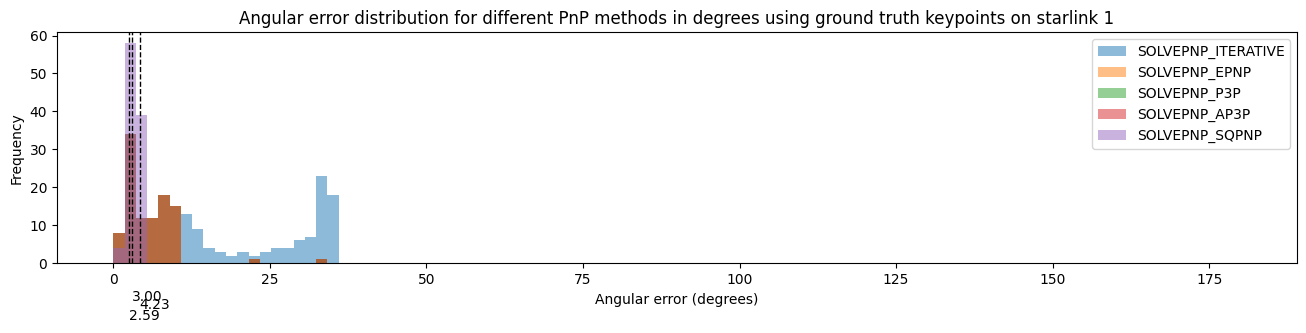

100%|██████████| 101/101 [00:00<00:00, 492.27it/s]


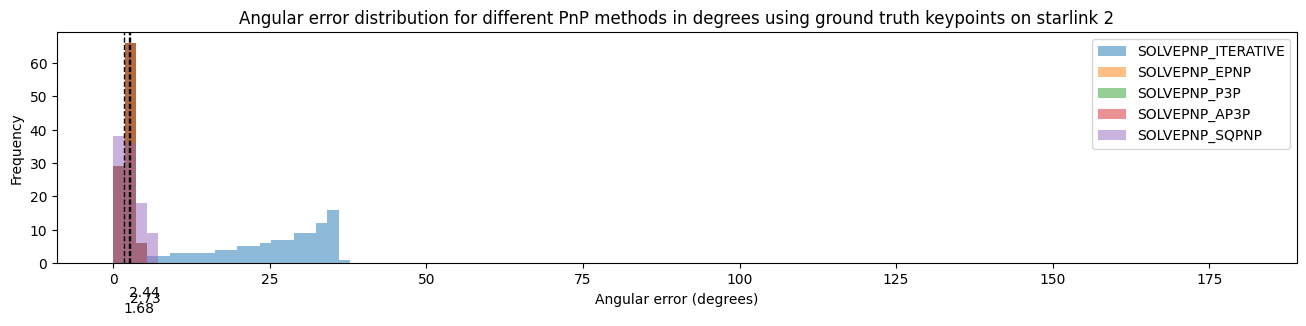

100%|██████████| 101/101 [00:00<00:00, 519.64it/s]


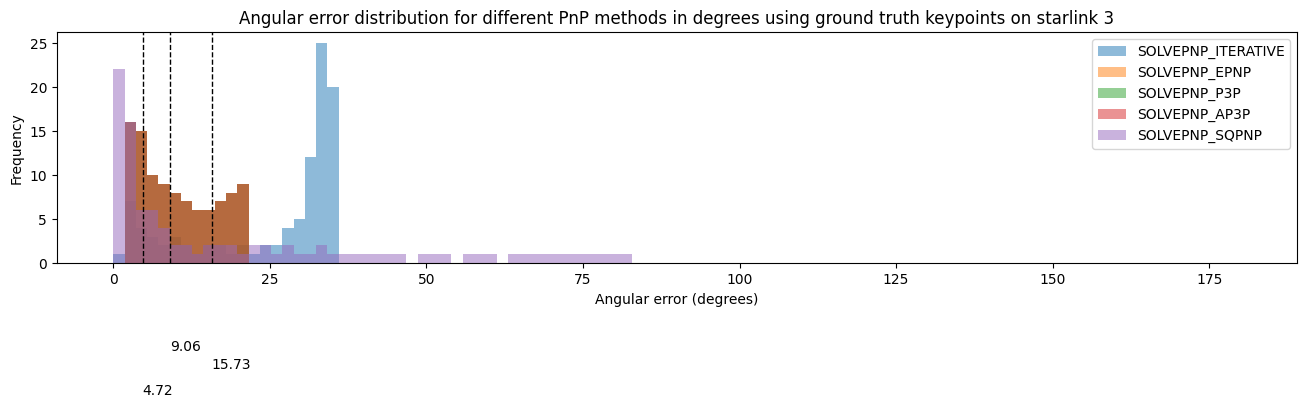

100%|██████████| 101/101 [00:00<00:00, 480.65it/s]


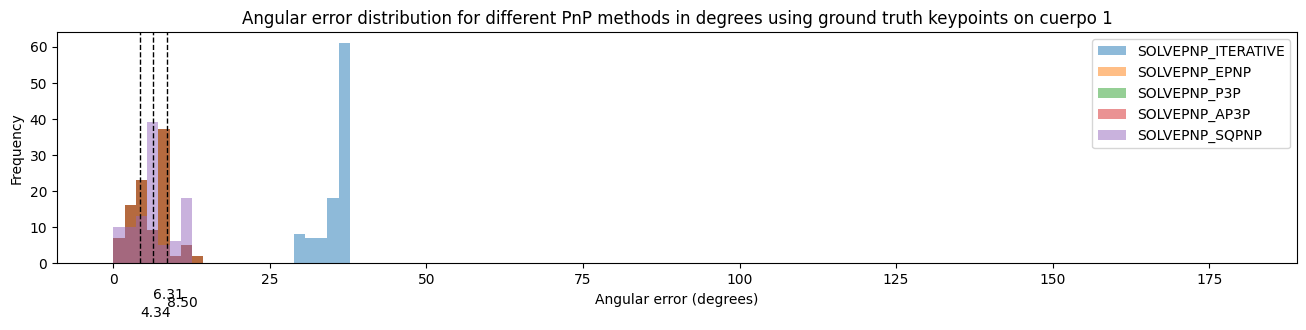

100%|██████████| 101/101 [00:00<00:00, 392.79it/s]


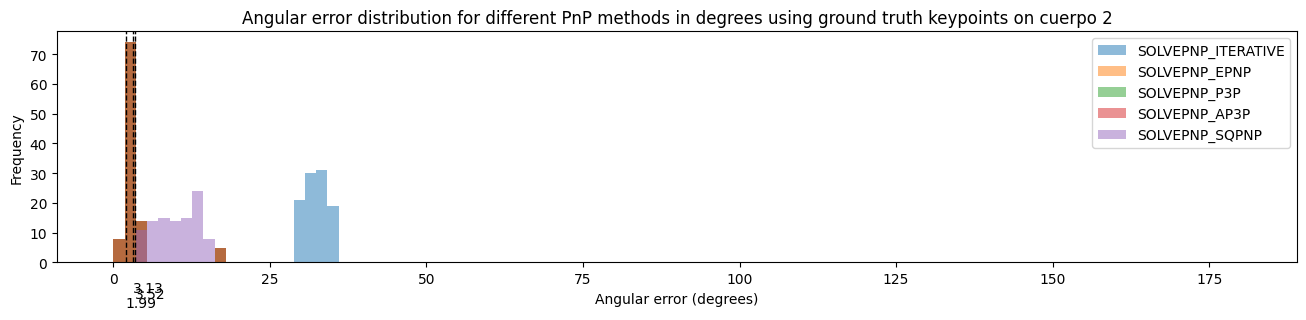

100%|██████████| 101/101 [00:00<00:00, 457.36it/s]


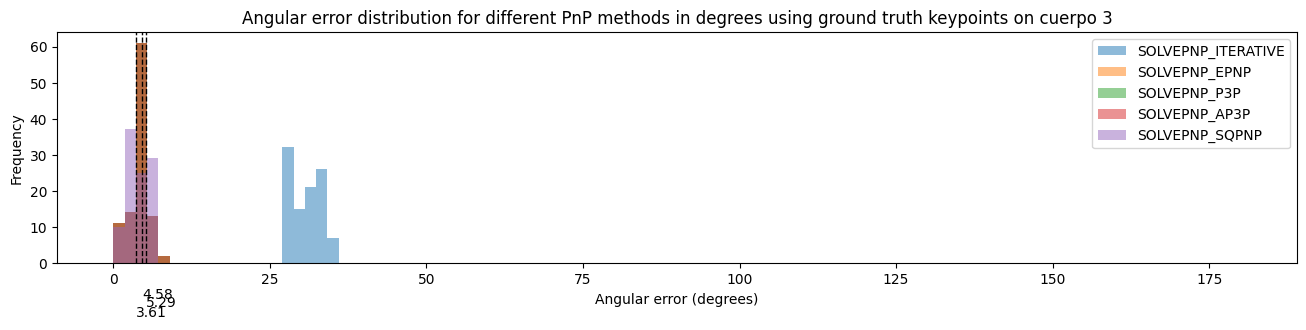

In [88]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/starlink_wpnp_filter_11_keypoints/1/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'starlink'
which_dataset = 1
compute_histograms()
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/starlink_wpnp_filter_11_keypoints/2/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'starlink'
which_dataset = 2
compute_histograms()
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/starlink_wpnp_filter_11_keypoints/3/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'starlink'
which_dataset = 3
compute_histograms()

dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/cuerpo_wpnp_filter_11_keypoints/1/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'cuerpo'
which_dataset = 1
compute_histograms()
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/cuerpo_wpnp_filter_11_keypoints/2/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'cuerpo'
which_dataset = 2
compute_histograms()
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/cuerpo_wpnp_filter_11_keypoints/3/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'cuerpo'
which_dataset = 3
compute_histograms()

100%|██████████| 101/101 [00:00<00:00, 139.28it/s]


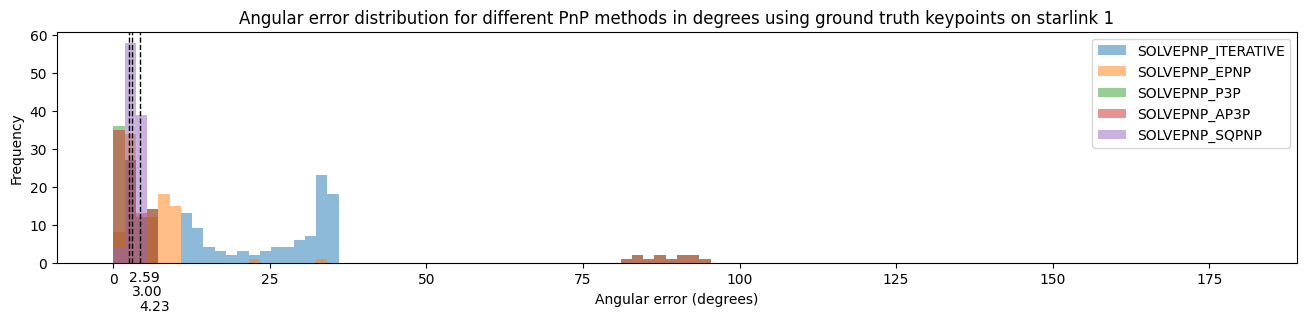

In [150]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/starlink_wpnp_filter_11_keypoints/1/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'starlink'
which_dataset = 1
angular_errors = []
l2_pts_errors = []


for json_file in tqdm.tqdm(json_files):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    # base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    # blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
    R = np.array(R)

    # r = Rotation.from_quat(np.array(R))
    # R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation methods
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
            # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
            estimated_rotation = Rotation.from_matrix(rotation_matrix)
            estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
            estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
            estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
        except:
            try:
                success, rotation_vector, translation_vector = cv2.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
                estimated_rotation = Rotation.from_matrix(rotation_matrix)
                estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
            except Exception as e:
                print(e)
                break
        
        # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
        angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
        ang_error_each.append(angular_distance)
    
    angular_errors.append(ang_error_each)

import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
plt.figure(figsize=(16,3))
num_bins = 100
min_bin = 0
max_bin = 180

plt.title(f'Angular error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
plt.hist(angular_errors[:,0], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_ITERATIVE', alpha=0.5);
plt.hist(angular_errors[:,1], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_EPNP', alpha=0.5);
plt.hist(angular_errors[:,2], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_P3P', alpha=0.5);
plt.hist(angular_errors[:,3], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_AP3P', alpha=0.5);
plt.hist(angular_errors[:,4], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_SQPNP', alpha=0.5);

min_q1 = (np.inf, np.inf)
for i in range(len(all_flags)):
    if np.quantile(angular_errors[:,i], 0.75) < min_q1[0]:
        min_q1 = (np.quantile(angular_errors[:,i], 0.75), i)

q1, q2, q3 = np.quantile(angular_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
# q1, q2, q3 = np.quantile(angular_errors[:,-1], [0.25, 0.5, 0.75])
plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
plt.text(q1, -5, f'{q1:.2f}')
plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
plt.text(q2, -8.5, f'{q2:.2f}')
plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
plt.text(q3, -12.5, f'{q3:.2f}')

plt.legend()
plt.xlabel('Angular error (degrees)')
plt.ylabel('Frequency')
plt.show()


100%|██████████| 101/101 [00:00<00:00, 184.53it/s]


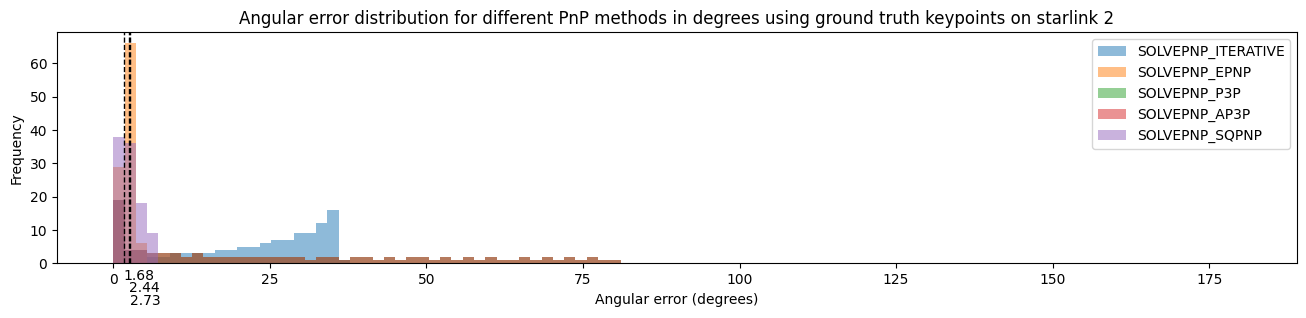

In [151]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/starlink_wpnp_filter_11_keypoints/2/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'starlink'
which_dataset = 2
angular_errors = []
l2_pts_errors = []


for json_file in tqdm.tqdm(json_files):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    # base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    # blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
    R = np.array(R)

    # r = Rotation.from_quat(np.array(R))
    # R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation methods
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
            # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
            estimated_rotation = Rotation.from_matrix(rotation_matrix)
            estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
            estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
            estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
        except:
            try:
                success, rotation_vector, translation_vector = cv2.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
                estimated_rotation = Rotation.from_matrix(rotation_matrix)
                estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
            except Exception as e:
                print(e)
                break
        
        # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
        angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
        ang_error_each.append(angular_distance)
    
    angular_errors.append(ang_error_each)

import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
plt.figure(figsize=(16,3))
num_bins = 100
min_bin = 0
max_bin = 180

plt.title(f'Angular error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
plt.hist(angular_errors[:,0], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_ITERATIVE', alpha=0.5);
plt.hist(angular_errors[:,1], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_EPNP', alpha=0.5);
plt.hist(angular_errors[:,2], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_P3P', alpha=0.5);
plt.hist(angular_errors[:,3], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_AP3P', alpha=0.5);
plt.hist(angular_errors[:,4], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_SQPNP', alpha=0.5);

min_q1 = (np.inf, np.inf)
for i in range(len(all_flags)):
    if np.quantile(angular_errors[:,i], 0.75) < min_q1[0]:
        min_q1 = (np.quantile(angular_errors[:,i], 0.75), i)

q1, q2, q3 = np.quantile(angular_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
# q1, q2, q3 = np.quantile(angular_errors[:,-1], [0.25, 0.5, 0.75])
plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
plt.text(q1, -5, f'{q1:.2f}')
plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
plt.text(q2, -8.5, f'{q2:.2f}')
plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
plt.text(q3, -12.5, f'{q3:.2f}')

plt.legend()
plt.xlabel('Angular error (degrees)')
plt.ylabel('Frequency')
plt.show()


  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 295.48it/s]

OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/calib3d/src/calibration.cpp:3537: error: (-2:Unspecified error) in function 'void cv::Rodrigues(cv::InputArray, cv::OutputArray, cv::OutputArray)'
> Input matrix must be 1x3 or 3x1 for a rotation vector, or 3x3 for a rotation matrix:
>     'srcSz == Size(3, 1) || srcSz == Size(1, 3) || (srcSz == Size(1, 1) && src.channels() == 3) || srcSz == Size(3, 3)'
> where
>     'srcSz' is [0 x 0]

OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/calib3d/src/calibration.cpp:3537: error: (-2:Unspecified error) in function 'void cv::Rodrigues(cv::InputArray, cv::OutputArray, cv::OutputArray)'
> Input matrix must be 1x3 or 3x1 for a rotation vector, or 3x3 for a rotation matrix:
>     'srcSz == Size(3, 1) || srcSz == Size(1, 3) || (srcSz == Size(1, 1) && src.channels() == 3) || srcSz == Size(3, 3)'
> where
>     'srcSz' is [0 x 0]

OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/

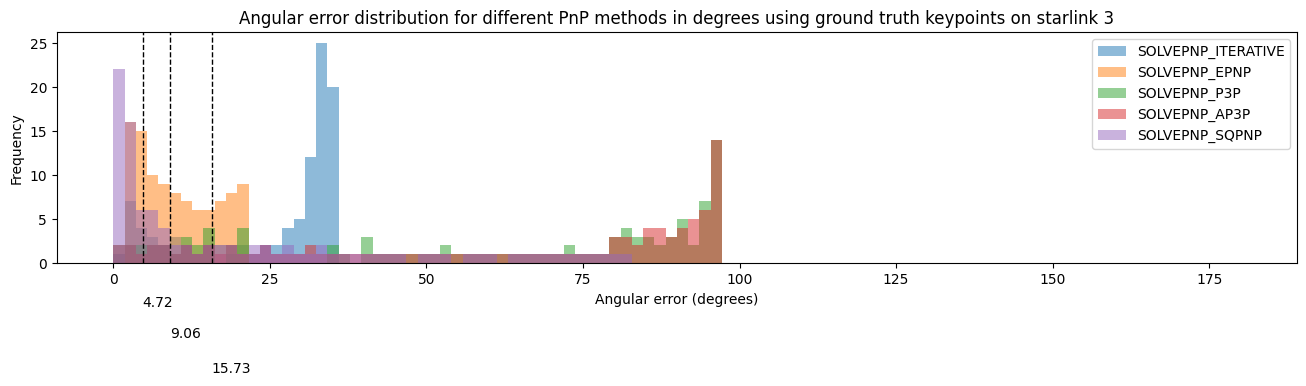

In [153]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/starlink_wpnp_filter_11_keypoints/3/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'starlink'
which_dataset = 3
angular_errors = []
l2_pts_errors = []


for json_file in tqdm.tqdm(json_files):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    # base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    # blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
    R = np.array(R)

    # r = Rotation.from_quat(np.array(R))
    # R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation methods
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
            estimated_rotation = Rotation.from_matrix(rotation_matrix)
            estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
            estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
            estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
        except:
            try:
                success, rotation_vector, translation_vector = cv2.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                estimated_rotation = Rotation.from_matrix(rotation_matrix)
                estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
            except Exception as e:
                print(e)
        
        # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
        angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
        ang_error_each.append(angular_distance)
    
    angular_errors.append(ang_error_each)

import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
plt.figure(figsize=(16,3))
num_bins = 100
min_bin = 0
max_bin = 180

plt.title(f'Angular error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
plt.hist(angular_errors[:,0], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_ITERATIVE', alpha=0.5);
plt.hist(angular_errors[:,1], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_EPNP', alpha=0.5);
plt.hist(angular_errors[:,2], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_P3P', alpha=0.5);
plt.hist(angular_errors[:,3], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_AP3P', alpha=0.5);
plt.hist(angular_errors[:,4], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_SQPNP', alpha=0.5);

min_q1 = (np.inf, np.inf)
for i in range(len(all_flags)):
    if np.quantile(angular_errors[:,i], 0.75) < min_q1[0]:
        min_q1 = (np.quantile(angular_errors[:,i], 0.75), i)

q1, q2, q3 = np.quantile(angular_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
# q1, q2, q3 = np.quantile(angular_errors[:,-1], [0.25, 0.5, 0.75])
plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
plt.text(q1, -5, f'{q1:.2f}')
plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
plt.text(q2, -8.5, f'{q2:.2f}')
plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
plt.text(q3, -12.5, f'{q3:.2f}')

plt.legend()
plt.xlabel('Angular error (degrees)')
plt.ylabel('Frequency')
plt.show()


In [172]:
world_keypoints = [
        [
            0.5285135507583618,
            3.9575204849243164,
            -0.17695434391498566
        ],
        [
            -0.6007072329521179,
            1.6536147594451904,
            -0.17696230113506317
        ],
        [0,1,2]]

In [173]:
world_keypoints = np.array(world_keypoints)

In [174]:
world_keypoints

array([[ 0.52851355,  3.95752048, -0.17695434],
       [-0.60070723,  1.65361476, -0.1769623 ],
       [ 0.        ,  1.        ,  2.        ]])

In [175]:
world_keypoints.flatten()

array([ 0.52851355,  3.95752048, -0.17695434, -0.60070723,  1.65361476,
       -0.1769623 ,  0.        ,  1.        ,  2.        ])

In [176]:
import torch

ModuleNotFoundError: No module named 'torch'

100%|██████████| 101/101 [00:00<00:00, 353.61it/s]


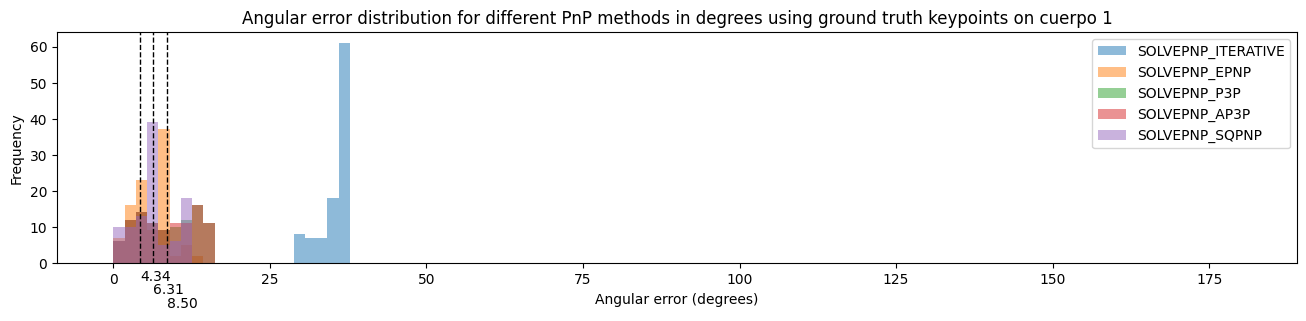

In [148]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/cuerpo_wpnp_filter_11_keypoints/1/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'cuerpo'
which_dataset = 1
angular_errors = []
l2_pts_errors = []


for json_file in tqdm.tqdm(json_files):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    # base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    # blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
    R = np.array(R)

    # r = Rotation.from_quat(np.array(R))
    # R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation methods
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
            # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
            estimated_rotation = Rotation.from_matrix(rotation_matrix)
            estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
            estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
            estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
        except:
            try:
                success, rotation_vector, translation_vector = cv2.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
                estimated_rotation = Rotation.from_matrix(rotation_matrix)
                estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
            except Exception as e:
                print(e)
                break
        
        # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
        angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
        ang_error_each.append(angular_distance)
    angular_errors.append(ang_error_each)

import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
plt.figure(figsize=(16,3))
num_bins = 100
min_bin = 0
max_bin = 180

plt.title(f'Angular error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
plt.hist(angular_errors[:,0], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_ITERATIVE', alpha=0.5);
plt.hist(angular_errors[:,1], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_EPNP', alpha=0.5);
plt.hist(angular_errors[:,2], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_P3P', alpha=0.5);
plt.hist(angular_errors[:,3], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_AP3P', alpha=0.5);
plt.hist(angular_errors[:,4], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_SQPNP', alpha=0.5);

min_q1 = (np.inf, np.inf)
for i in range(len(all_flags)):
    if np.quantile(angular_errors[:,i], 0.75) < min_q1[0]:
        min_q1 = (np.quantile(angular_errors[:,i], 0.75), i)

q1, q2, q3 = np.quantile(angular_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
# q1, q2, q3 = np.quantile(angular_errors[:,-1], [0.25, 0.5, 0.75])
plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
plt.text(q1, -5, f'{q1:.2f}')
plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
plt.text(q2, -8.5, f'{q2:.2f}')
plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
plt.text(q3, -12.5, f'{q3:.2f}')

plt.legend()
plt.xlabel('Angular error (degrees)')
plt.ylabel('Frequency')
plt.show()


100%|██████████| 101/101 [00:00<00:00, 220.75it/s]


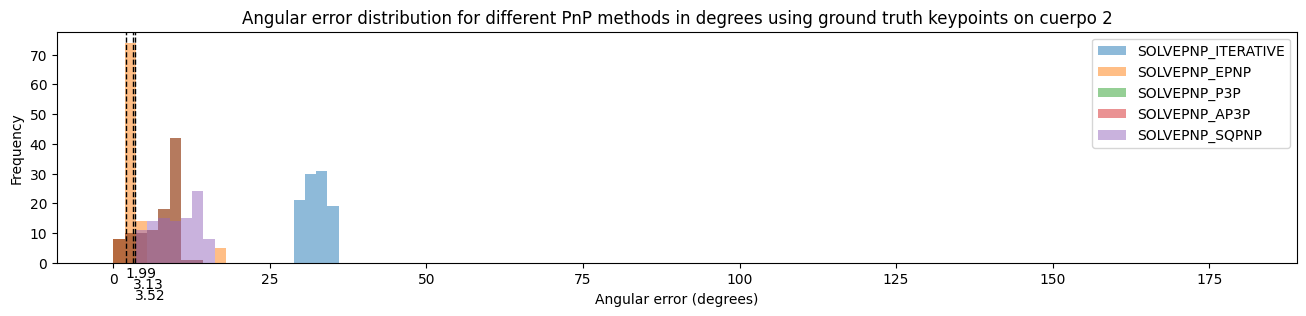

In [149]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/cuerpo_wpnp_filter_11_keypoints/2/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'cuerpo'
which_dataset = 2
angular_errors = []
l2_pts_errors = []


for json_file in tqdm.tqdm(json_files):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    # base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    # blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
    R = np.array(R)

    # r = Rotation.from_quat(np.array(R))
    # R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation methods
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
            # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
            estimated_rotation = Rotation.from_matrix(rotation_matrix)
            estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
            estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
            estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
        except:
            try:
                success, rotation_vector, translation_vector = cv2.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
                estimated_rotation = Rotation.from_matrix(rotation_matrix)
                estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
            except Exception as e:
                print(e)
                break
        
        # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
        angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
        ang_error_each.append(angular_distance)
    
    angular_errors.append(ang_error_each)

import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
plt.figure(figsize=(16,3))
num_bins = 100
min_bin = 0
max_bin = 180

plt.title(f'Angular error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
plt.hist(angular_errors[:,0], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_ITERATIVE', alpha=0.5);
plt.hist(angular_errors[:,1], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_EPNP', alpha=0.5);
plt.hist(angular_errors[:,2], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_P3P', alpha=0.5);
plt.hist(angular_errors[:,3], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_AP3P', alpha=0.5);
plt.hist(angular_errors[:,4], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_SQPNP', alpha=0.5);

min_q1 = (np.inf, np.inf)
for i in range(len(all_flags)):
    if np.quantile(angular_errors[:,i], 0.75) < min_q1[0]:
        min_q1 = (np.quantile(angular_errors[:,i], 0.75), i)

q1, q2, q3 = np.quantile(angular_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
# q1, q2, q3 = np.quantile(angular_errors[:,-1], [0.25, 0.5, 0.75])
plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
plt.text(q1, -5, f'{q1:.2f}')
plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
plt.text(q2, -8.5, f'{q2:.2f}')
plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
plt.text(q3, -12.5, f'{q3:.2f}')

plt.legend()
plt.xlabel('Angular error (degrees)')
plt.ylabel('Frequency')
plt.show()


100%|██████████| 101/101 [00:00<00:00, 163.91it/s]


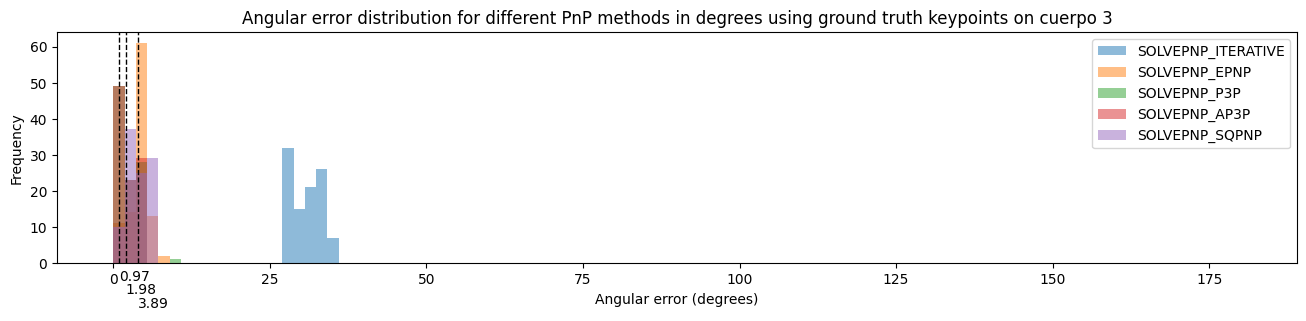

In [147]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/cuerpo_wpnp_filter_11_keypoints/3/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'cuerpo'
which_dataset = 3
angular_errors = []
l2_pts_errors = []


for json_file in tqdm.tqdm(json_files):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    # base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    # blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
    R = np.array(R)

    # r = Rotation.from_quat(np.array(R))
    # R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation methods
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
            # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
            estimated_rotation = Rotation.from_matrix(rotation_matrix)
            estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
            estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
            estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
        except:
            try:
                success, rotation_vector, translation_vector = cv2.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                # rotation_matrix[[0,1]] = rotation_matrix[[1,0]]
                estimated_rotation = Rotation.from_matrix(rotation_matrix)
                estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
            except Exception as e:
                print(e)
                break
        
        # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
        angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
        ang_error_each.append(angular_distance)
    
    angular_errors.append(ang_error_each)

import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
plt.figure(figsize=(16,3))
num_bins = 100
min_bin = 0
max_bin = 180

plt.title(f'Angular error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
plt.hist(angular_errors[:,0], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_ITERATIVE', alpha=0.5);
plt.hist(angular_errors[:,1], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_EPNP', alpha=0.5);
plt.hist(angular_errors[:,2], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_P3P', alpha=0.5);
plt.hist(angular_errors[:,3], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_AP3P', alpha=0.5);
plt.hist(angular_errors[:,4], bins=num_bins, range=(min_bin, max_bin), label='SOLVEPNP_SQPNP', alpha=0.5);

min_q1 = (np.inf, np.inf)
for i in range(len(all_flags)):
    if np.quantile(angular_errors[:,i], 0.75) < min_q1[0]:
        min_q1 = (np.quantile(angular_errors[:,i], 0.75), i)

q1, q2, q3 = np.quantile(angular_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
# q1, q2, q3 = np.quantile(angular_errors[:,-1], [0.25, 0.5, 0.75])
plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
plt.text(q1, -5, f'{q1:.2f}')
plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
plt.text(q2, -8.5, f'{q2:.2f}')
plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
plt.text(q3, -12.5, f'{q3:.2f}')

plt.legend()
plt.xlabel('Angular error (degrees)')
plt.ylabel('Frequency')
plt.show()


### translation errors

In [167]:
dataset_path ='/Users/dk/Documents.nosync/msc-project/datasets/filtering/cuerpo_wpnp_filter_11_keypoints/2/data/*.json'
json_files = glob.glob(dataset_path)
satellite = 'cuerpo'
which_dataset = 2
multipliers = np.array(list(itertools.product([1, -1], repeat=3)))
permutations = np.array(list(itertools.permutations([0, 1, 2])))


# p = np.array([0, 2, 1])
# m = np.array([-1, -1, 1])
# json_files = glob.glob('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/*.json')

for p in tqdm.tqdm(permutations):
    for m in multipliers:
        
        # angular_errors = []
        # l2_pts_errors = []
        
        for json_file in json_files:

            angular_errors = []
            l2_pts_errors = []

            example_data = json.loads(open(json_file).read())
            base_world_pts = np.array(example_data['world_keypoints'])
            base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
            observed_pts   = np.array(example_data['sensor_keypoints'])
            
            observed_pts[:, [0, 1]] = -1*observed_pts[:, [1, 0]]

            K = np.array(example_data['intrinsic_matrix'])
            # K = np.eye(3)
            # K = np.array([[1, 0, 0],
                        #   [0, 1, 0],
                        #   [0, 0, 1]])

            R = example_data['pose']        # this is a quaternion in WXYZ Blender Mathutils format
            R = np.array(R)
            t = example_data['translation']
            t = np.array(t)

            K = np.hstack((K, np.zeros((3,1))))
            Xworld = np.array(base_world_pts)
            Xcam = np.array(observed_pts)
            A = np.array(K)

            # run EPnP
            # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
            
            ########  ---------------------------------------rotation methods
            all_flags = [
                'SOLVEPNP_ITERATIVE', 
                'SOLVEPNP_EPNP', 
                'SOLVEPNP_P3P', 
                'SOLVEPNP_AP3P', 
                'SOLVEPNP_SQPNP'
            ]

            ang_error_each = []
            l2_error_each = []
            for flag in all_flags:
                try:
                    success, rotation_vector, translation_vector = cv2.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv2.__dict__[flag])
                    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                    estimated_rotation = Rotation.from_matrix(rotation_matrix)
                    estimated_rotation = estimated_rotation.as_quat()     # convert rotation estimate to a quaternion
                    estimated_rotation = np.array(estimated_rotation)     # reverse order of quaternion elements, as scipy returns XYZW quaternion format
                    estimated_rotation = np.roll(estimated_rotation, 1)   # XYZW -> WXYZ
                except: 
                    print('1')
                
                # compute geodesic angular distance between ground truth and estimate quaternions, in degrees
                # angular_distance = 180 - np.arccos(np.clip(2*(np.dot(R, estimated_rotation)**2)-1, -1.0, 1.0))*180/np.pi
                # ang_error_each.append(angular_distance)

                # compute L2 distance between ground truth and estimate translation vectors
                t[[0,1]] = -1*t[[1,0]]
                l2_distance = np.linalg.norm(t - translation_vector)
                l2_error_each.append(l2_distance)
            
            l2_pts_errors.append(l2_error_each)
            angular_errors.append(ang_error_each)

            import matplotlib.pyplot as plt
            angular_errors = np.array(angular_errors)
            l2_pts_errors  = np.array(l2_pts_errors)
            # plt.figure(figsize=(16,3))

            # plt.title(f'L2 error distribution for different PnP methods in degrees using ground truth keypoints on {satellite} {which_dataset}')
            # plt.hist(l2_pts_errors[:,0], label='SOLVEPNP_ITERATIVE', alpha=0.5);
            # plt.hist(l2_pts_errors[:,1], label='SOLVEPNP_EPNP', alpha=0.5);
            # plt.hist(l2_pts_errors[:,2], label='SOLVEPNP_P3P', alpha=0.5);
            # plt.hist(l2_pts_errors[:,3], label='SOLVEPNP_AP3P', alpha=0.5);
            # plt.hist(l2_pts_errors[:,4], label='SOLVEPNP_SQPNP', alpha=0.5);
            print(p, m)
            print(np.quantile(l2_pts_errors[:,0], 0.75))
            print(np.quantile(l2_pts_errors[:,1], 0.75))
            print(np.quantile(l2_pts_errors[:,2], 0.75))
            print(np.quantile(l2_pts_errors[:,3], 0.75))
            print(np.quantile(l2_pts_errors[:,4], 0.75))


            # min_q1 = (np.inf, np.inf)
            # for i in range(len(all_flags)):
            #     if np.quantile(l2_pts_errors[:,i], 0.75) < min_q1[0]:
            #         min_q1 = (np.quantile(l2_pts_errors[:,i], 0.75), i)

            # q1, q2, q3 = np.quantile(l2_pts_errors[:,min_q1[-1]], [0.25, 0.5, 0.75])
            # plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
            # plt.text(q1, -5, f'{q1:.2f}')
            # plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
            # plt.text(q2, -8.5, f'{q2:.2f}')
            # plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
            # plt.text(q3, -12.5, f'{q3:.2f}')

            # plt.legend()
            # plt.xlabel('L2 error')
            # plt.ylabel('Frequency')
            # plt.show()
            # print('ok')


  0%|          | 0/6 [00:00<?, ?it/s]

1
1
1
[0 1 2] [1 1 1]
36508.4339245767
34696.798255602254
34696.798255602254
34696.798255602254
34696.798255602254
1
1
1
[0 1 2] [1 1 1]
38475.64421156626
36157.777021753136
36157.777021753136
36157.777021753136
36157.777021753136
1
1
1
[0 1 2] [1 1 1]
34299.4130419964
32353.986199640334
32353.986199640334
32353.986199640334
32353.986199640334
1
1
1
[0 1 2] [1 1 1]
35523.88367529723
31217.85672884014
31217.85672884014
31217.85672884014
31217.85672884014
1
1
1
[0 1 2] [1 1 1]
34136.86334590166
31689.93110612886
31689.93110612886
31689.93110612886
31689.93110612886
1
1
1
[0 1 2] [1 1 1]
34965.1907247757
31140.388877830264
31140.388877830264
31140.388877830264
31140.388877830264
1
1
1
[0 1 2] [1 1 1]
34458.54846221968
32610.915595138973
32610.915595138973
32610.915595138973
32610.915595138973
1
1
1
[0 1 2] [1 1 1]
34182.06673235469
31618.55103575891
31618.55103575891
31618.55103575891
31618.55103575891
1
1
1
[0 1 2] [1 1 1]
34756.23999121427
31201.00219199002
31201.00219199002
31201.00219

 17%|█▋        | 1/6 [00:04<00:20,  4.01s/it]

1
1
1
[0 1 2] [-1 -1 -1]
35127.79730052413
31130.28409377942
31130.28409377942
31130.28409377942
31130.28409377942
1
1
1
[0 2 1] [1 1 1]
36540.66111862636
34293.18253362561
34293.18253362561
34293.18253362561
34293.18253362561
1
1
1
[0 2 1] [1 1 1]
38508.88112270135
37056.55925430731
37056.55925430731
37056.55925430731
37056.55925430731
1
1
1
[0 2 1] [1 1 1]
34329.36783690112
31025.85228182198
31025.85228182198
31025.85228182198
31025.85228182198
1
1
1
[0 2 1] [1 1 1]
35549.63325526429
37839.47159808077
37839.47159808077
37839.47159808077
37839.47159808077
1
1
1
[0 2 1] [1 1 1]
34165.4713387185
30268.46880663946
30268.46880663946
30268.46880663946
30268.46880663946
1
1
1
[0 2 1] [1 1 1]
34991.86463828401
30068.05667947591
30068.05667947591
30068.05667947591
30068.05667947591
1
1
1
[0 2 1] [1 1 1]
34488.8399352773
31317.953948041177
31317.953948041177
31317.953948041177
31317.953948041177
1
1
1
[0 2 1] [1 1 1]
34210.422181683985
30185.856122026256
30185.856122026256
30185.856122026256
3

 33%|███▎      | 2/6 [00:08<00:17,  4.31s/it]

1
1
1
[0 2 1] [-1 -1 -1]
36030.24304694557
33576.85830191221
33576.85830191221
33576.85830191221
33576.85830191221
1
1
1
[0 2 1] [-1 -1 -1]
38703.60014797732
37328.84989665437
37328.84989665437
37328.84989665437
37328.84989665437
1
1
1
[0 2 1] [-1 -1 -1]
35588.58034599576
40512.970095044344
40512.970095044344
40512.970095044344
40512.970095044344
1
1
1
[0 2 1] [-1 -1 -1]
34297.459129432
30960.297871004674
30960.297871004674
30960.297871004674
30960.297871004674
1
1
1
[0 2 1] [-1 -1 -1]
34142.99330386527
30368.11137070478
30368.11137070478
30368.11137070478
30368.11137070478
1
1
1
[0 2 1] [-1 -1 -1]
35154.219059243114
30124.817791486363
30124.817791486363
30124.817791486363
30124.817791486363
1
1
1
[1 0 2] [1 1 1]
36540.66111701667
33822.56213650988
33822.56213650988
33822.56213650988
33822.56213650988
1
1
1
[1 0 2] [1 1 1]
38508.8811247931
35090.25786036575
35090.25786036575
35090.25786036575
35090.25786036575
1
1
1
[1 0 2] [1 1 1]
34329.3678326579
44628.10915754244
44628.10915754244
4

 50%|█████     | 3/6 [00:12<00:11,  3.95s/it]

1
1
1
[1 0 2] [-1 -1 -1]
34733.80487608474
45151.84787665718
45151.84787665718
45151.84787665718
45151.84787665718
1
1
1
[1 0 2] [-1 -1 -1]
35588.393857371
33299.17501644466
33299.17501644466
33299.17501644466
33299.17501644466
1
1
1
[1 0 2] [-1 -1 -1]
34444.10282119966
49614.12157995699
49614.12157995699
49614.12157995699
49614.12157995699
1
1
1
[1 0 2] [-1 -1 -1]
35414.73106388973
36703.83005495554
36703.83005495554
36703.83005495554
36703.83005495554
1
1
1
[1 0 2] [-1 -1 -1]
34938.43969336785
40898.847266648605
40898.847266648605
40898.847266648605
40898.847266648605
1
1
1
[1 0 2] [-1 -1 -1]
36151.303138271716
33599.95961235803
33599.95961235803
33599.95961235803
33599.95961235803
1
1
1
[1 0 2] [-1 -1 -1]
34192.997988815
35954.49939930437
35954.49939930437
35954.49939930437
35954.49939930437
1
1
1
[1 0 2] [-1 -1 -1]
36030.241844991804
33532.96987949172
33532.96987949172
33532.96987949172
33532.96987949172
1
1
1
[1 0 2] [-1 -1 -1]
38703.60015009011
35228.4312924905
35228.4312924905
3

 67%|██████▋   | 4/6 [00:16<00:08,  4.22s/it]

1
[1 2 0] [-1 -1 -1]
35629.516421610846
36041.81262913845
36041.81262913845
36041.81262913845
36041.81262913845
1
1
1
[1 2 0] [-1 -1 -1]
34111.93793505737
31814.872101744575
31814.872101744575
31814.872101744575
31814.872101744575
1
1
1
[1 2 0] [-1 -1 -1]
35235.27223145521
34817.32912553284
34817.32912553284
34817.32912553284
34817.32912553284
1
1
1
[1 2 0] [-1 -1 -1]
34732.81627887128
32414.143098780456
32414.143098780456
32414.143098780456
32414.143098780456
1
1
1
[1 2 0] [-1 -1 -1]
34304.80486329693
35750.7830811116
35750.7830811116
35750.7830811116
35750.7830811116
1
1
1
[1 2 0] [-1 -1 -1]
34611.94661989873
33182.23531440885
33182.23531440885
33182.23531440885
33182.23531440885
1
1
1
[1 2 0] [-1 -1 -1]
35360.85933698634
32980.507192580575
32980.507192580575
32980.507192580575
32980.507192580575
1
1
1
[1 2 0] [-1 -1 -1]
34139.92438474719
31814.967426974534
31814.967426974534
31814.967426974534
31814.967426974534
1
1
1
[1 2 0] [-1 -1 -1]
35073.496971836146
34389.95284618965
34389.952

 83%|████████▎ | 5/6 [00:20<00:04,  4.22s/it]

1
1
1
[2 0 1] [-1 -1 -1]
38869.7246462384
36419.61185467499
36419.61185467499
36419.61185467499
36419.61185467499
1
1
1
[2 0 1] [-1 -1 -1]
34149.478636809836
31665.38874874064
31665.38874874064
31665.38874874064
31665.38874874064
1
1
1
[2 0 1] [-1 -1 -1]
36244.6434069505
34475.632930621025
34475.632930621025
34475.632930621025
34475.632930621025
1
1
1
[2 0 1] [-1 -1 -1]
34858.89331885005
31164.222382190605
31164.222382190605
31164.222382190605
31164.222382190605
1
1
1
[2 0 1] [-1 -1 -1]
34372.51713084289
32478.272277248532
32478.272277248532
32478.272277248532
32478.272277248532
1
1
1
[2 0 1] [-1 -1 -1]
35436.350319097524
31185.726868840422
31185.726868840422
31185.726868840422
31185.726868840422
1
1
1
[2 0 1] [-1 -1 -1]
35456.824364666994
33759.76886019868
33759.76886019868
33759.76886019868
33759.76886019868
1
1
1
[2 0 1] [-1 -1 -1]
34658.5695844461
31248.469037218005
31248.469037218005
31248.469037218005
31248.469037218005
1
1
1
[2 0 1] [-1 -1 -1]
34224.23758998092
31572.4992065088


100%|██████████| 6/6 [00:25<00:00,  4.22s/it]

1
1
1
[2 1 0] [-1 -1 -1]
34158.06061111407
33703.4799036664
33703.4799036664
33703.4799036664
33703.4799036664
1
1
1
[2 1 0] [-1 -1 -1]
35300.195460273324
33158.081850113
33158.081850113
33158.081850113
33158.081850113
1
1
1
[2 1 0] [-1 -1 -1]
34594.29070397401
44382.241158650235
44382.241158650235
44382.241158650235
44382.241158650235
1
1
1
[2 1 0] [-1 -1 -1]
34303.70993218248
38617.886599982456
38617.886599982456
38617.886599982456
38617.886599982456
1
1
1
[2 1 0] [-1 -1 -1]
34701.627304545545
32916.83246936281
32916.83246936281
32916.83246936281
32916.83246936281
1
1
1
[2 1 0] [-1 -1 -1]
35208.16126320781
36200.01010440665
36200.01010440665
36200.01010440665
36200.01010440665
1
1
1
[2 1 0] [-1 -1 -1]
34140.66503981717
33343.773652750286
33343.773652750286
33343.773652750286
33343.773652750286
1
1
1
[2 1 0] [-1 -1 -1]
34220.08530798417
38473.33927879468
38473.33927879468
38473.33927879468
38473.33927879468
1
1
1
[2 1 0] [-1 -1 -1]
35681.598017585464
37172.20344403762
37172.2034440376